In [1]:
# 라이브러리를 불러옵니다.
import numpy as np
import pandas as pd
from itertools import combinations
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

In [2]:
# 데이터를 불러옵니다.
data = pd.read_csv('./data/anti_depressant_prescription.csv')

In [3]:
# 데이터의 첫 다섯 줄을 출력합니다.
print(data.shape)
data.head()

(160683, 15)


,기준년도,가입자일련번호,처방내역일련번호,일련번호,성별코드,연령대코드(5세단위),시도코드,요양개시일자,약품일반성분명코드,1회 투약량,1일투약량,총투여일수,단가,금액,데이터 공개일자
0,2017,62,7819529,2,1,12,41,20170711,242901ATB,2.0,1,28,40.0,2240,20181126
1,2017,62,35429246,2,1,12,41,20170808,242901ATB,2.0,1,28,40.0,2240,20181126
2,2017,62,37765102,5,1,12,41,20170609,242901ATB,2.0,1,28,40.0,2240,20181126
3,2017,62,59976553,5,1,12,41,20170911,242901ATB,2.0,1,28,40.0,2240,20181126
4,2017,107,21130660,1,1,11,47,20171017,495501ACE,1.0,1,30,404.0,12120,20181126


In [4]:
# 처방내역일련번호로 그룹화하여 처방된 약품의 개수를 세어봅니다.
pd.DataFrame(data.groupby('처방내역일련번호')['약품일반성분명코드'].count().value_counts()).T

약품일반성분명코드,1,2,3,4,5,6
count,118338,16650,2546,287,41,9


### 약품일반성분명코드란?
**약품일반성분명코드** 또는 **주성분코드**는 의약품의 대표하는 성분에 대한 코드입니다. \
총 9자리로 구성되어 있으며 구성은 아래와 같습니다. 앞 4자리의 주성분 일련번호가 동일하면 동일한 성분으로 생각할 수 있습니다.

![주성분코드](img/주성분코드.png)

이후로는 Main Ingredient Code (MI_code)라고 지칭하도록 하겠습니다.

In [5]:
# 자주 사용할 컬럼의 이름을 바꿔줍니다.
data.rename(columns={'가입자일련번호': 'uid',  # user id
                     '처방내역일련번호': 'pid',  # prescription id
                     '약품일반성분명코드': 'mi_code'}, inplace=True)

### 예시 확인 (마지막 파일에선 제거)

In [6]:
data[data['pid'] == 2630689]

,기준년도,uid,pid,일련번호,성별코드,연령대코드(5세단위),시도코드,요양개시일자,mi_code,1회 투약량,1일투약량,총투여일수,단가,금액,데이터 공개일자
17284,2017,103504,2630689,4,1,14,28,20170609,203401ATB,1.0,1,28,49.0,1372,20181126
17285,2017,103504,2630689,5,1,14,28,20170609,203401ATB,2.0,1,28,49.0,2744,20181126
17286,2017,103504,2630689,7,1,14,28,20170609,242902ATB,4.0,1,28,84.0,9408,20181126
17287,2017,103504,2630689,8,1,14,28,20170609,495501ACE,1.0,1,28,404.0,11312,20181126
17288,2017,103504,2630689,10,1,14,28,20170609,196202ATB,1.0,1,28,935.0,26180,20181126


In [7]:
data[data['uid'] == 103504]

,기준년도,uid,pid,일련번호,성별코드,연령대코드(5세단위),시도코드,요양개시일자,mi_code,1회 투약량,1일투약량,총투여일수,단가,금액,데이터 공개일자
17279,2017,103504,298526,4,1,14,28,20170504,203401ATB,1.0,1,28,49.0,1372,20181126
17280,2017,103504,298526,5,1,14,28,20170504,203401ATB,2.0,1,28,49.0,2744,20181126
17281,2017,103504,298526,7,1,14,28,20170504,242902ATB,4.0,1,28,84.0,9408,20181126
17282,2017,103504,298526,8,1,14,28,20170504,495502ACE,1.0,1,28,624.0,17472,20181126
17283,2017,103504,298526,10,1,14,28,20170504,196202ATB,1.0,1,28,935.0,26180,20181126
17284,2017,103504,2630689,4,1,14,28,20170609,203401ATB,1.0,1,28,49.0,1372,20181126
17285,2017,103504,2630689,5,1,14,28,20170609,203401ATB,2.0,1,28,49.0,2744,20181126
17286,2017,103504,2630689,7,1,14,28,20170609,242902ATB,4.0,1,28,84.0,9408,20181126
17287,2017,103504,2630689,8,1,14,28,20170609,495501ACE,1.0,1,28,404.0,11312,20181126
17288,2017,103504,2630689,10,1,14,28,20170609,196202ATB,1.0,1,28,935.0,26180,20181126


In [8]:
# 한 환자당 처방전의 개수를 세어봅니다.
data.groupby('uid')['pid'].count().describe()

count    33344.000000
mean         4.818948
std          6.553291
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        152.000000
Name: pid, dtype: float64

한 사람당 여러번의 처방전이 발부될 수 있고, 그 처방전들 중 같은 약을 포함하기도하고 다른 약을 포함하기도 한다는 것을 볼 수 있습니다.

두 종류의 약물이 같이 처방된 빈도 수를 계산할 때, 같은 사람에게 여러번 처방된 케이스는 같이 처방된 횟수로 나누어야 한다고 판단했습니다.

그렇지 않으면 한사람에게 여러번 처방된 약들이 weight에 불평등한 영향을 미칠 것으로 예상됩니다.

---

In [9]:
def process_patient_data(patient_groups):
    # 페어 카운트를 저장할 Counter 초기화
    pair_counts = Counter()
    
    for patient_id, group in patient_groups:
        # 해당 환자의 모든 처방 가져오기
        prescriptions = group.groupby('pid')['mi_code'].apply(list)
        
        # 해당 환자의 유니크 약물 주성분 페어와 자기 자신 루프를 저장할 집합
        patient_pairs = set()
        patient_self_loops = set()
        
        # 해당 환자에게 처방된 모든 유니크 약물 주성분 페어와 자기 자신 루프 수집
        for meds in prescriptions:
            # 처방 내 각 약물 주성분의 발생 횟수 계산
            med_counts = Counter(meds)
            
            # 한 번 이상 나타나는 약물 주성분 식별 (self-loop)
            for med, count in med_counts.items():
                if count > 1:
                    patient_self_loops.add(med)
            
            # 페어 조합을 위한 처방 내 유니크 약물 주성분 가져오기
            unique_meds_in_prescription = set(meds)
            pairs = combinations(unique_meds_in_prescription, 2)
            patient_pairs.update(pairs)
        
        # 해당 환자의 유니크 페어를 글로벌 페어 카운트에 업데이트
        pair_counts.update(patient_pairs)
        
        # 자기 자신 루프를 글로벌 페어 카운트에 업데이트
        for med in patient_self_loops:
            pair_counts[(med, med)] += 1

    return pair_counts

Adjacency matrix를 만드는 함수를 정의합니다.

- 대각선을 기준으로 대칭
- 같은 성분의 약물이 중복적으로 처방될 경우를 고려 (self-loop)

In [10]:
def build_adjacency_matrix(pair_counts, med_to_index):
    # 페어 카운트를 사용하여 인접 행렬 채우기
    adj_matrix = np.zeros((len(med_to_index), len(med_to_index)))
    
    for (med1, med2), count in pair_counts.items():
        idx1 = med_to_index[med1]
        idx2 = med_to_index[med2]
        adj_matrix[idx1][idx2] = count
        if med1 != med2:
            adj_matrix[idx2][idx1] = count  # 대칭 페어의 경우
        else:
            adj_matrix[idx1][idx2] = count  # 자기 자신 루프 (대각선 요소)
    
    return adj_matrix

시험용 테스트 데이터를 만들어 함수들이 제대로 작동하는 지 확인해 보겠습니다.

In [11]:
# 테스트 데이터프레임 생성
test_data = {
    "uid": [1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3], 
    "pid": [101, 101, 101, 201, 201, 202, 202, 202, 301, 301, 301], 
    "mi_code": [1, 2, 3, 2, 1, 1, 2, 3, 1, 1, 1] 
}
df_test = pd.DataFrame(test_data)

# 약품 코드를 인덱스로 매핑
unique_meds = df_test["mi_code"].unique()
med_to_index = {med: idx for idx, med in enumerate(unique_meds)}

# 환자별 그룹화
patient_groups = df_test.groupby('uid')

# 페어 카운트 처리
pair_counts = process_patient_data(patient_groups)

# 인접 행렬 생성
adj_matrix = build_adjacency_matrix(pair_counts, med_to_index)

# 결과 인접 행렬이 올바른지 확인
expected_adj_matrix = np.array([[1., 2., 2.], [2., 0., 2.], [2., 2., 0.]])
assert np.array_equal(adj_matrix, expected_adj_matrix)

이제 실제 데이터에 적용하겠습니다.

In [12]:
# 약품 코드를 인덱스로 매핑
unique_meds = data["mi_code"].unique()
med_to_index = {med: idx for idx, med in enumerate(unique_meds)}

# 환자별 그룹화
patient_groups = data.groupby('uid')

# 페어 카운트 처리
pair_counts = process_patient_data(patient_groups)

# 인접 행렬 생성
adj_matrix = build_adjacency_matrix(pair_counts, med_to_index)

# 인접 행렬을 데이터프레임으로 변환
df_adjacency_matrix = pd.DataFrame(adj_matrix, index=unique_meds, columns=unique_meds)

In [13]:
# 인접 행렬의 일부만 출력합니다.
df_adjacency_matrix.iloc[:5, :5]

,242901ATB,495501ACE,474801ATB,107501ATB,196201ATB
242901ATB,15.0,34.0,3.0,22.0,43.0
495501ACE,34.0,16.0,4.0,130.0,1.0
474801ATB,3.0,4.0,30.0,28.0,1.0
107501ATB,22.0,130.0,28.0,88.0,2.0
196201ATB,43.0,1.0,1.0,2.0,13.0


In [30]:
# 주성분 매핑 데이터프레임을 불러옵니다.
df_mapping = pd.read_csv('./data/anti_depressant_mapping.csv')

# 주성분 이름을 약자로 변환한 컬럼을 추가합니다.
df_mapping['주성분약자'] = df_mapping['주성분명'].apply(lambda x: x[:3])

# 주성분 코드를 주성분 이름으로 매핑하는 딕셔너리를 생성합니다.
mi_code_to_abbrev = df_mapping.set_index('주성분코드')['주성분약자'].to_dict()

## 그래프 시각화
이제 NetworkX를 통해 시각화를 해주도록 하겠습니다.

In [15]:
# adjacency matrix를 networkx 그래프로 변환합니다.
G = nx.from_pandas_adjacency(df_adjacency_matrix)

C:\Users\YuHan\AppData\Local\Temp\ipykernel_15656\1997310112.py:16: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)


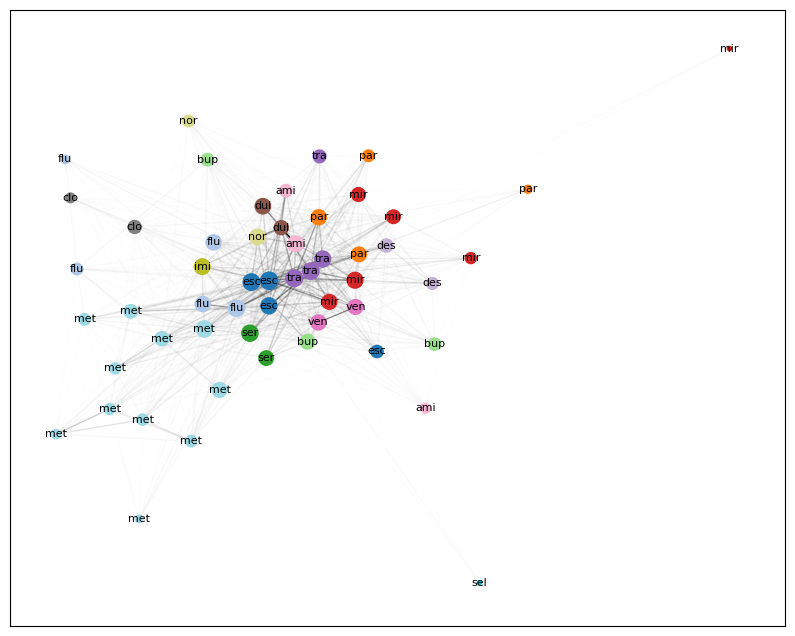

In [39]:
# 그래프를 그립니다.
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# 노드의 크기를 degree centrality에 비례하게 설정합니다.
node_size = [G.degree(node) * 3 for node in G.nodes]

# 노드의 색상을 주성분 이름의 약자에 따라 설정합니다.
encode_abbrev = {abbrev: idx for idx, abbrev in enumerate(df_mapping['주성분약자'].unique())}
node_color_by_abbrev = [encode_abbrev[mi_code_to_abbrev[node]] for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color_by_abbrev, cmap=plt.cm.tab20)

# 엣지의 투명도를 weight에 비례하게 설정합니다.
max_weight = max([d['weight'] for u, v, d in G.edges(data=True)])
for edge in G.edges(data="weight"):
    nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)

# 인덱스를 이용한 노드 레이블링을 합니다.
labels = {node: mi_code_to_abbrev[node] for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.show()

각 숫자를 해당하는 주성분에 매핑해주도록 하겠습니다.

C:\Users\YuHan\AppData\Local\Temp\ipykernel_15656\4179510509.py:4: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)


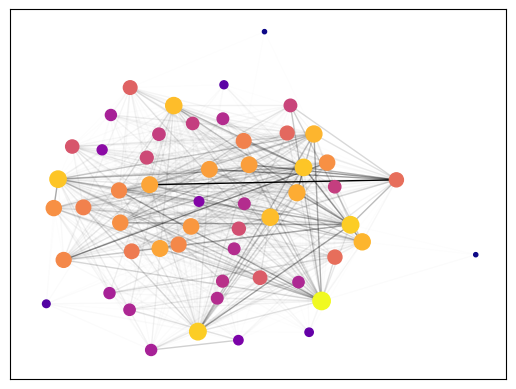

In [18]:
pos = nx.kamada_kawai_layout(G) #positions for all nodes

for edge in G.edges(data="weight"):
    nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)

nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.plasma)
plt.show()

C:\Users\YuHan\AppData\Local\Temp\ipykernel_15656\4200247507.py:4: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)


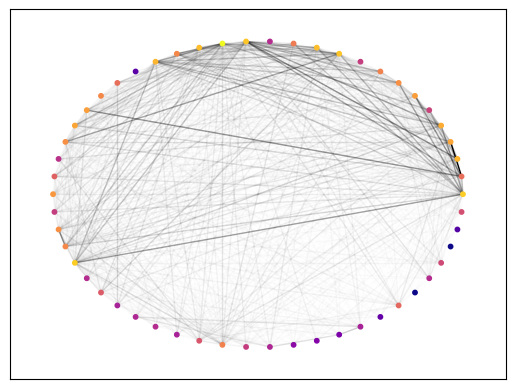

In [19]:
pos = nx.circular_layout(G) #positions for all nodes

for edge in G.edges(data="weight"):
    nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)

nx.draw_networkx_nodes(G, pos, node_size=10, node_color=node_color, cmap=plt.cm.plasma)